#Music Generation with RNNs
In this code, we will explore building a Recurrent Neural Network (RNN) for music generation. We will train a model to learn the patterns in raw sheet music in ABC notation and then use this model to generate new music.

[Installing Dependencies](#1)

[Loading the DataSets](#2)

[Process the dataset for the learning task](#3)

[Training examples and targets](#4)

[The Recurrent Neural Network (RNN) model](#5)

[Define the RNN model](#6)

[Test out the RNN model](#7)

[Predictions from the untrained model](#8)

[Training the model: loss and training operations](#10)

<a id = '1'></a>

## Dependencies 
First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

Change the run time setting to **GPU** if using **Google Colab**

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
# using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

<a id = '2'></a>

## Dataset
The dataset consists of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset and inspect it:


```
-Thanks MIT for providing the data sets
```




In [ ]:
# Download the dataset
songs = mdl.lab1.load_training_data()

#Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)


To convert a song in ABC notation to an audio waveform and play it back. 



In [ ]:
# Convert the ABC notation to audio file and listen to it
mdl.lab1.play_song(example_song)


One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters that are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined  = "\n\n".join(songs)

#find all unique character in the joined string 
vocab = sorted(set(songs_joined))
print("There are", len(vocab), " unique characters in the dataset")



<a id = '3'></a>

# Process the dataset for the learning task
Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information.

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task.

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.


## Vectorize the text
Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

The below code is an example of how enumerate() funtion is working . This is just for an understanding purpose

In [ ]:
arr = ['apple', 'bananana' , 'pineapple']
e =[]
for i in arr:
    e = enumerate(arr)
print(list(e))


In [ ]:
#Define numerical representation of test

#Create a mapping from character to unique index
#For example, to get the index of the character "d"
# We can evaluvate 'char2idx["d"]

char2idx ={u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.

idx2char = np.array(vocab)


This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to len(unique). Let's take a peek at this numerical representation of our dataset:

In [ ]:
print('{')
for char,_ in zip(char2idx,range(20)):
    print("  {:4s}:{:3d}," . format(repr(char) ,char2idx[char]))
print("  ...\n")

In [ ]:
### Vectorize the songs string ###

def vectorize_string(string):
    vectorize_output = np.array([char2idx[char] for char in string])
    return vectorize_output

vectorized_songs = vectorize_string(songs_joined)

We can also look at how the first part of the text is mapped to an integer representation:

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))

assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

<a id = '4'></a>

## Create training examples and targets
The next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain seq_length characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of seq_length+1. Suppose seq_length is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs , seq_length , batch_size):
    # the length of the vectorized songs string
    n = vectorized_songs.shape[0]-1
    idx = np.random.choice(n-seq_length , batch_size)
    
    
    input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
    
    output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
    
    # x_batch, y_batch provide the true inputs and targets for network training
    x_batch = np.reshape(input_batch ,[batch_size ,seq_length])
    y_batch = np.reshape(output_batch ,[batch_size ,seq_length])
    return x_batch,y_batch

test_args = (vectorized_songs , 10 , 2)
if not mdl.lab1.test_batch_func_types(get_batch,test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch,test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch,test_args):
    print("===================\n[FAIL] could nopt pass tests")
else:
    print("===================\n[PASS] passed all tests!")


For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the RNN considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [ ]:
x_batch,y_batch = get_batch(vectorized_songs,seq_length=5, batch_size =1)

for i , (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch),np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("    input: {} ({:s})" .format(input_idx,repr(idx2char[input_idx])))
    print("    expected output : {} ({:s})" .format(target_idx , repr(idx2char[target_idx])))

<a id = '5'></a>

## The Recurrent Neural Network (RNN) model
Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected Dense layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character.

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, **tf.keras.Sequential**, to define the model. Three layers are used to define the model:

**tf.keras.layers.Embedding**: This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with embedding_dim dimensions.

**tf.keras.layers.LSTM**: Our LSTM network, with size units=rnn_units.

**tf.keras.layers.Dense**: The output layer, with vocab_size outputs.

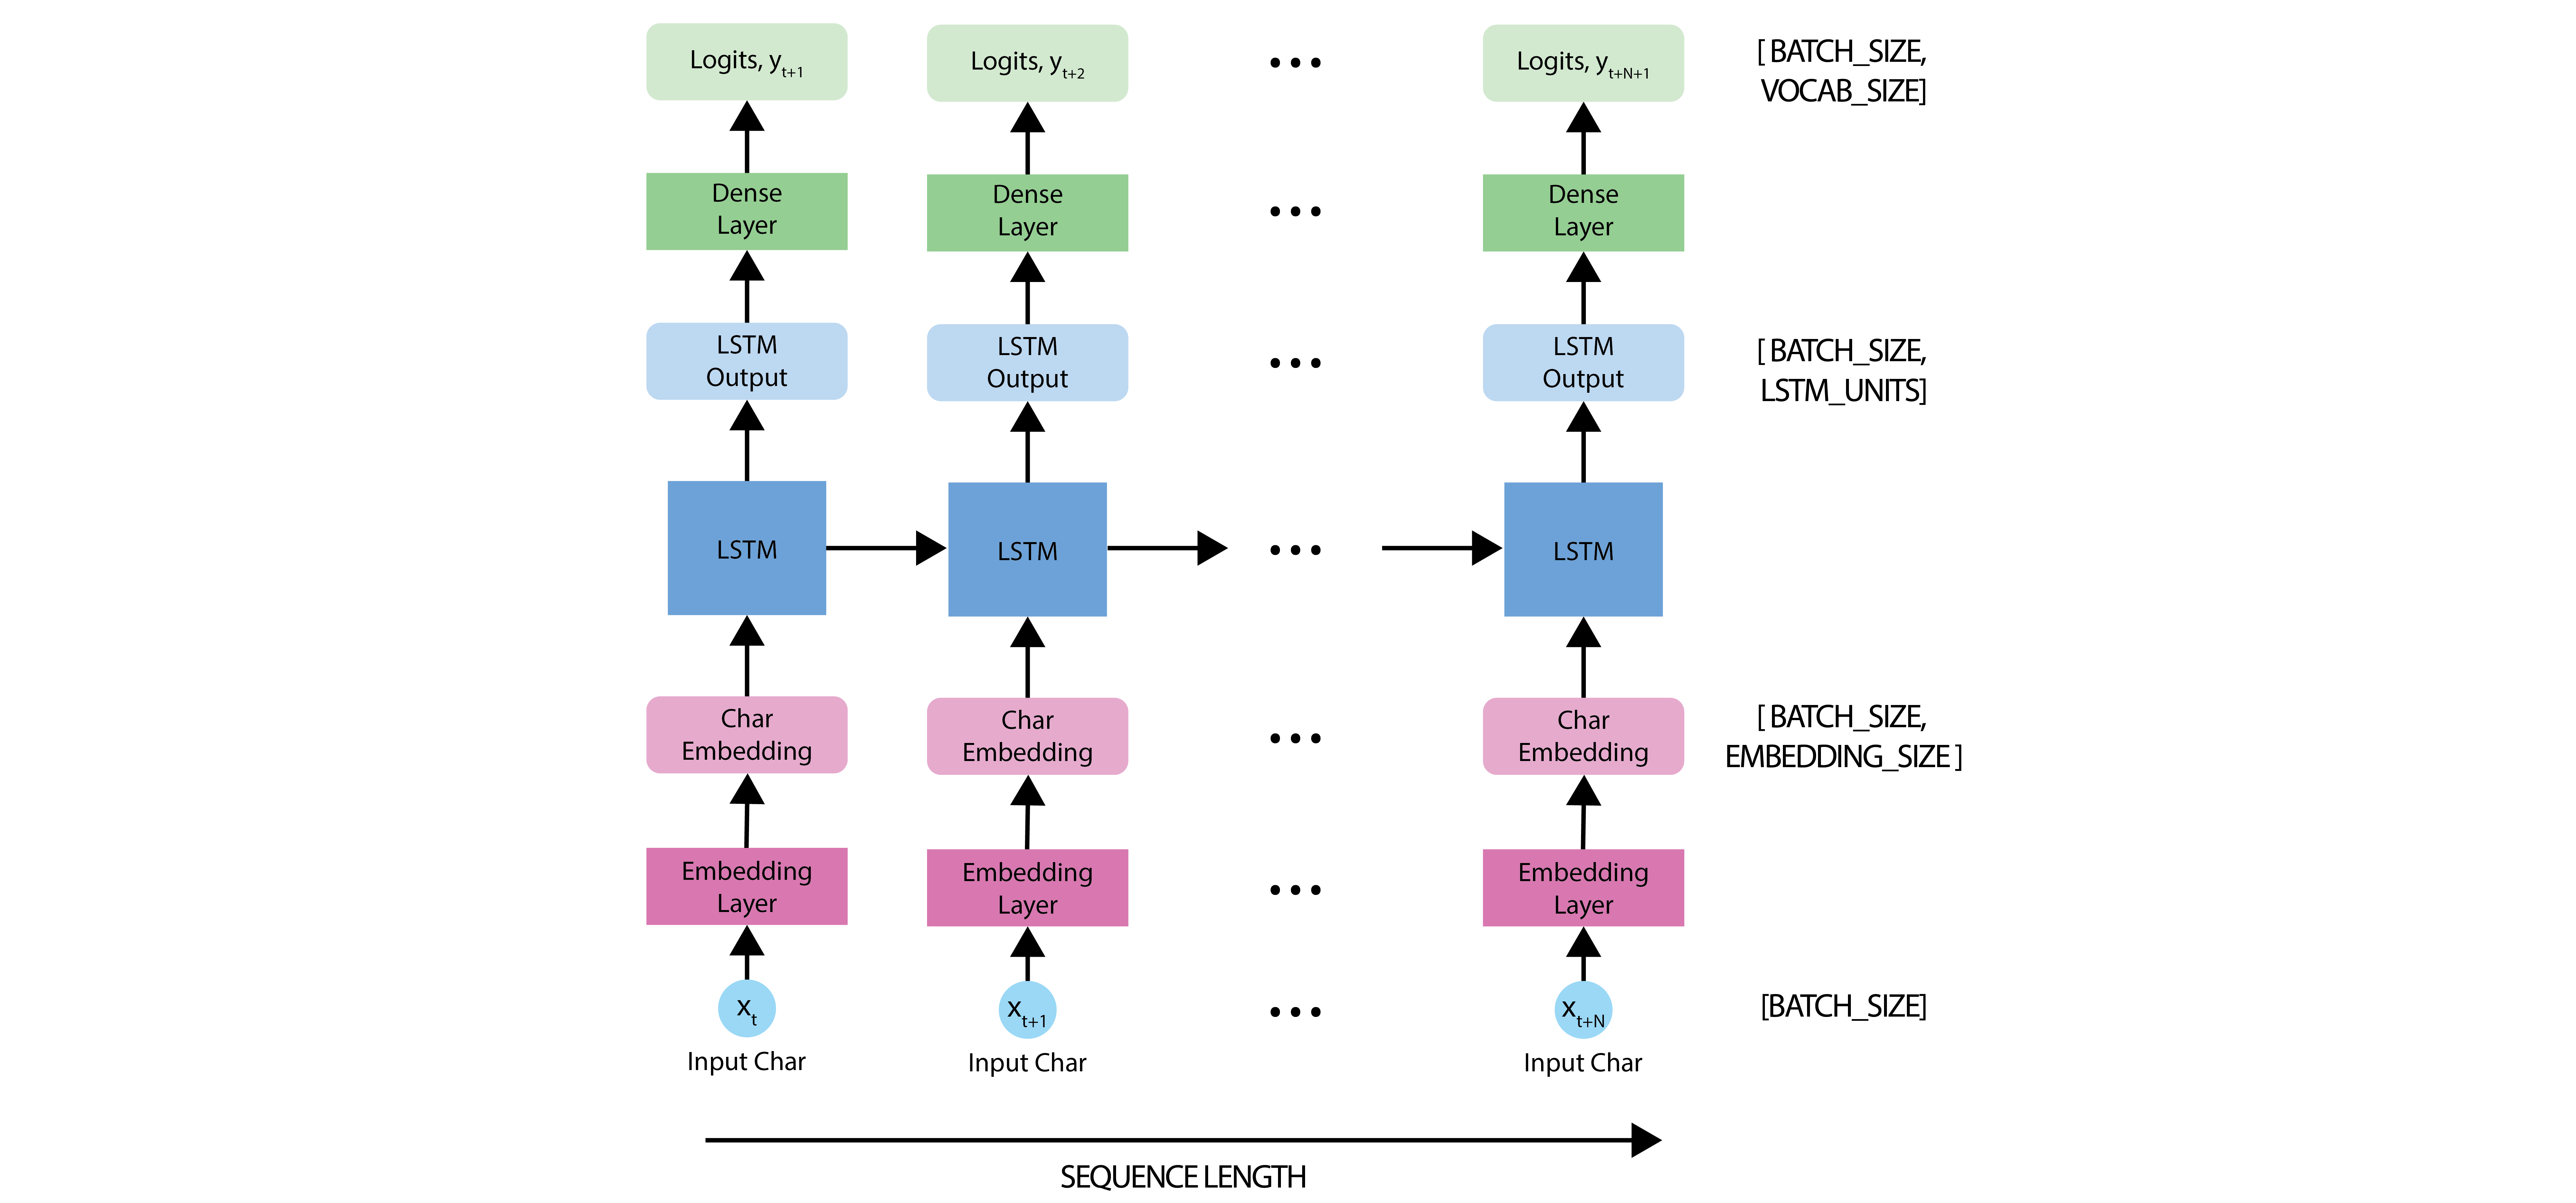


<a id = '6'></a>

## Define the RNN model
Now, we will define a function that we will use to actually build the model

In [ ]:
def LSTM(rnn_units):
    return tf.keras.layers.LSTM(rnn_units,
                               return_sequences = True ,
                               recurrent_initializer = 'glorot_uniform',
                               recurrent_activation = 'sigmoid',
                               stateful = True,)

In [ ]:
###Defining the RNN Model ###

def build_model(vocab_size , embedding_dim, rnn_units ,batch_size):
    model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size   
                                tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_input_shape =[batch_size,None]),
    # Layer 2: LSTM with `rnn_units` number of units. 
                                LSTM(rnn_units),
    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
                                tf.keras.layers.Dense(vocab_size)
    ])
    
    return model

model =build_model(len(vocab) , embedding_dim = 256 , rnn_units = 1024 , batch_size = 32)

<a id = '7'></a>

## Test out the RNN model
It's always a good idea to run a few simple checks on our model to see that it behaves as expected.

First, we can use the Model.summary function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [ ]:
model.summary()

We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [ ]:
x,y = get_batch(vectorized_songs, seq_length = 100, batch_size = 32)
pred = model(x)
print(" input shape       :  ", x.shape, " # (batch_size, sequence_lenght)")
print(" predicition shape :  " , pred.shape,  "#(batch_size ,sequence_length,vocab_size)")

<a id = '8'></a>

## Predictions from the untrained model
Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a softmax over our character vocabulary. This will give us actual character indices. This means we are using a categorical distribution to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep.

Note here that we sample from this probability distribution, as opposed to simply taking the argmax, which can cause the model to get stuck in a loop.



In [ ]:
sampled_indicies = tf.random.categorical(pred[0],num_samples=1)
sampled_indices = tf.squeeze(sampled_indicies,axis=-1).numpy()

we can now decode these to see the text  predicited by the untrained model:

In [ ]:
print("input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("". join(idx2char[sampled_indices])))

As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? We can train the network!

<a id = '8'></a>

<a id = '10'></a>

## Training the model: loss and training operations
Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. Given the previous state of the RNN, as well as the input at a given time step, we want to predict the class of the next character -- that is, to actually predict the next character.

To train our model on this classification task, we can use a form of the crossentropy loss (negative log likelihood loss). Specifically, we will use the sparse_categorical_crossentropy loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets -- the labels -- and the predicted targets -- the logits.

Let's first compute the loss using our example predictions from the untrained model:

In [ ]:
### Defining the loss function ###

def compute_loss(labels ,logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels , logits , from_logits = True)
    return loss

examples_batch_loss  = compute_loss(y,pred)

print("Predicition shape: " , pred.shape, " #(batch_size , sequence_length , vocab_size)")
print("scalar_loss      : " , examples_batch_loss.numpy().mean())

Let's start by defining some hyperparameters for training the model. To start, we have provided some reasonable values for some of the parameters. It is up to you to use what we've learned in class to help optimize the parameter selection here!

In [ ]:

### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000
batch_size = 4
seq_length = 100
learning_rate = 5e-3

#Model parameters
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

#check point loaction
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


Now, we are ready to define our training operation -- the optimizer and duration of training -- and use this function to train the model. You will experiment with the choice of optimizer and the duration for which you train your models, and see how these changes affect the network's output. Some optimizers you may like to try are Adam and Adagrad.

First, we will instantiate a new model and an optimizer. Then, we will use the tf.GradientTape method to perform the backpropagation operations.

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss.

In [ ]:

### Define optimizer and training operation ###

model = build_model(vocab_size,embedding_dim,rnn_units,batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function

def train_step(x,y):
    with tf.GradientTape() as tape:
    
        y_hat = model(x)
        
        loss = compute_loss(y,y_hat)
        
    grads = tape.gradient(loss , model.trainable_variables)
    
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2,xlabel='Iterations',ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for iter in tqdm(range(num_training_iterations)):

    x_batch , y_batch = get_batch(vectorized_songs ,seq_length ,batch_size)
    
    loss = train_step(x_batch,y_batch)
    
    history.append(loss.numpy().mean())
    plotter.plot(history)
    
    if iter % 100 == 0:
        model.save_weights(checkpoint_prefix)
        

                            
                            

In [ ]:
model.save_weights(checkpoint_prefix)



##**2.6 Generate music using the RNN model**
Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a softmax over possible successive characters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!


##Restore the latest checkpoint
To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built.

To run the model with a different batch_size, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [ ]:
model = build_model(vocab_size,embedding_dim,rnn_units,batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1,None]))

model.summary()


Notice that we have fed in a fixed batch_size of 1 for inference.

##The prediction procedure
Now, we're ready to write the code to generate text in the ABC music format:

Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

Use the start string and the RNN state to obtain the probability distribution over the next predicted character.

Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

At each time step, the updated RNN state is fed back into the model, so that it now has more context in making the next prediction. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.



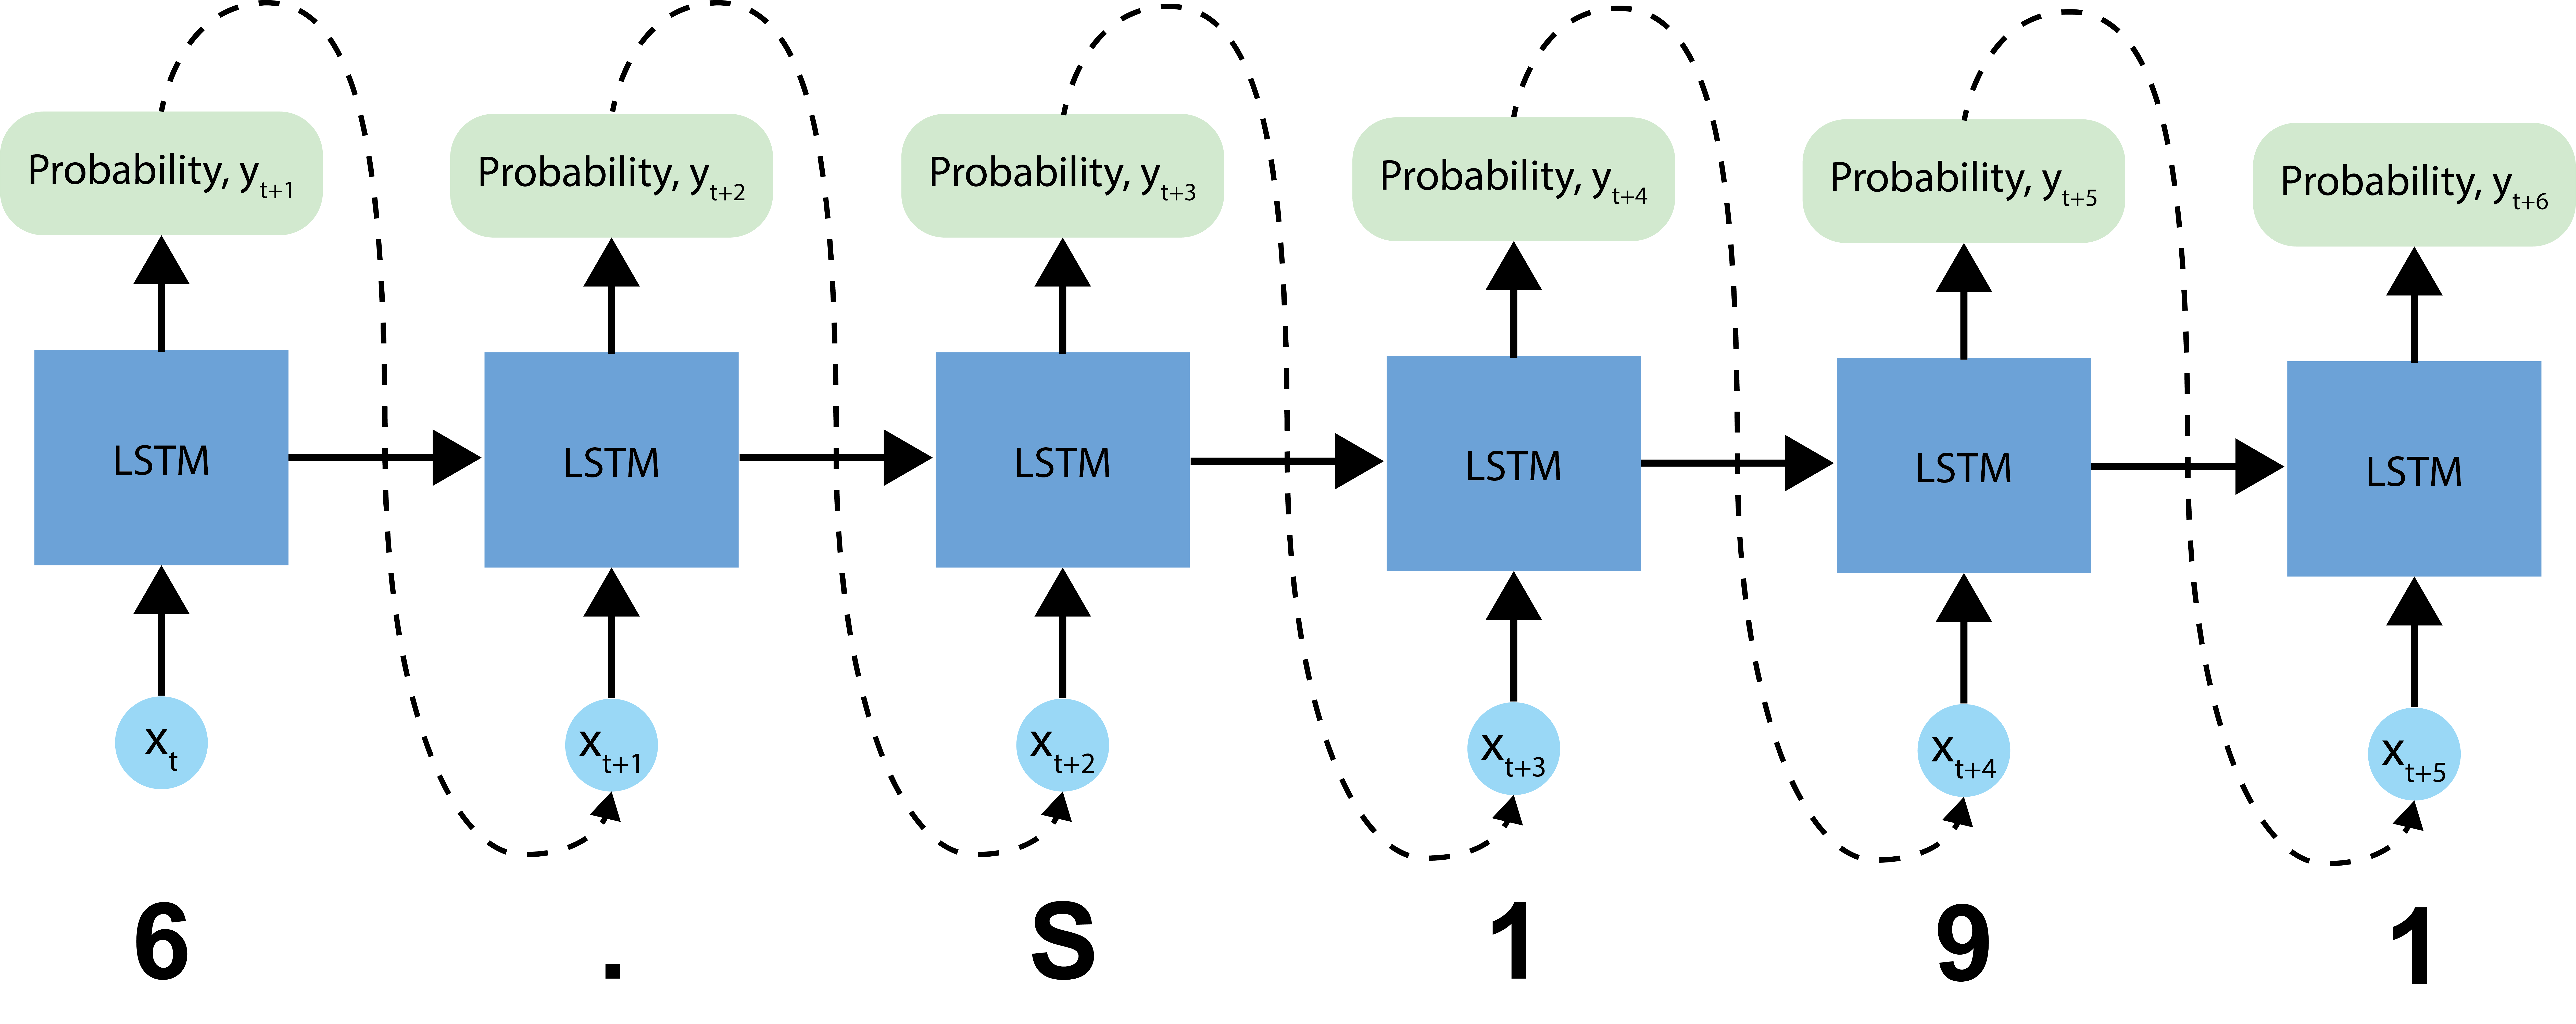

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

In [ ]:

### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)


  input_eval = [char2idx[s] for s in start_string] # TODO
  # input_eval = ['''TODO''']
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      # predictions = model('''TODO''')
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      # predicted_id = tf.random.categorical('''TODO''', num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id]) # TODO 
      # text_generated.append('''TODO''')
    
  return (start_string + ''.join(text_generated))


In [ ]:

generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO
# generated_text = generate_text('''TODO''', start_string="X", generation_length=1000)